# NUDT15: Analysis & Paper figures

Author:  
Matteo Cagiada | matteo.cagiada@bio.ku.dk

NUDT15 MAVE datasets, necessary to run the notebook, can be downloaded from:  
- Suiter, et al, 2020 (https://doi.org/10.1073/pnas.1915680117)

## Libraries, functions, dictionaries and parameters

In [208]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy.optimize import curve_fit
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import gaussian_kde

from pylab import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn2, venn2_circles
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [209]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [210]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

In [211]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [212]:
def load_data(data,wt_seq):
    df=pd.read_csv(data, sep=' ', comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,1])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    print(mutation_load)
    for i in range(len(mutation_load)):
        #print(int(mutation_load[i][1:len(mutation_load[i])-1])-1, " ",alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1) #mutation_load[i][1:len(mutation_load[i])-2])-1, " ")
        scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

In [213]:
def heatmap_scores(ext_score,label_cm,WT_mask,lim_down,lim_up,color):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20
    score=np.copy(ext_score)
    fig, ax = plt.subplots(figsize=(20,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')

    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up)
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)

    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation")
    plt.xlabel("residue")
    plt.ylim(-0.5,19.5)
    
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_L_D[WT_mask[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')

In [214]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):                   
    #plot the distribution of the input data (can be a vector or matrix)
    #three different normalization option: off, density (matplotlib standard normalization), True: Frobenius-norm based 
    # thr: threshold for count the variants under a custom threshold
    
    mpl.rcParams['figure.figsize']=(9,7)    
    mpl.rcParams['axes.axisbelow'] = True
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_under=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_under+=counts[i]
    print('over threshold variants:',np.sum(counts)-sum_under, ' (', (np.sum(counts)-sum_under)/np.sum(counts)*100 ,'%)')
    

In [215]:
def count_variants_regions(class_matrix):
#count the variants present in each region in the input matrix
    
    count_reg=np.zeros((4,1),dtype=int)
    
    for i in range(class_matrix.shape[0]):
        for j in range(class_matrix.shape[1]):
            if np.isnan(class_matrix[i,j]) == False:
                count_reg[int(class_matrix[i,j])-1]+=1
                
    return count_reg

In [216]:
def heatmap_classification_WT(ext_score,WT_seq,region_spec='all',color_spec=[]):
# Plot the heatmap of the input color based classification matrix
# It's possible to plot only one of the region using the region number
# It's mandatory for the single region plot to assign a color using a list with two colors

    score=np.copy(ext_score)
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=5
    
    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]

    #plot of the entire classification heatmap with the current color scheme.
    if region_spec=='all':
        ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442","#56b4e9", "#009e74","#5A5A5A"]))

    # this part manages the plot of specific region, the other one are set to 0 and the designed region is set to 1 (binary map) 
    else:
        for i in range(score.shape[0]):
            for j in range(score.shape[1]):
                if np.isnan(score[i,j]) == True:
                    pass
                else:
                    if score[i,j] == region_spec:
                        score[i,j]=1
                    else:
                        score[i,j]=0
        for i in range(len(WT_seq)):
            score[i,alphabetAA_L_D[WT_seq[i]]-1]=2
        ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(color_spec))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation")
    plt.xlabel("residue")

    plt.ylim(-0.5,19.5)

In [217]:
def scores_density_plot(score1, score2,label_x,label_y):
    mpl.rcParams['figure.figsize']=(10,10)
    y=[]; x=[]
    for i in range(score1.shape[0]):
        for j in range(score1.shape[1]):
            if np.isnan(score1[i,j]) or np.isnan(score2[i,j]):
                pass
            else:
                x.append(float(score1[i,j]))
                y.append(float(score2[i,j]))
    x=np.array(x)
    y=np.array(y)
    xy= np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.grid(alpha=0.3)
    ax.set_axisbelow(True)
    plt.ylabel(label_y)
    plt.xlabel(label_x)
    ax.scatter(x, y, c=z, s=100, edgecolor='')    
    r=sp.stats.pearsonr(x,y)
    r2=sp.stats.spearmanr(x,y)
    print("Pearson's correlation coefficient between data: ",r[0])
    print("Pearson's correlation coefficient between data: ",r2[0])
    
    return r[0]

In [218]:
def classification_histogram_shadowed(score_back,score_filter,nbin,b_min,b_max,color,label_x,region_ext):
    # Function for plot the MAVE coloured variants distribution using the computational scores
    
    mpl.rcParams['figure.figsize']=(6,3)    
    mpl.rcParams['axes.axisbelow'] = True
    mpl.rcParams['xtick.labelsize'] = 14
    mpl.rcParams['ytick.labelsize'] = 14
    mpl.rcParams['axes.labelsize']  = 15
    
    temp=np.copy(score_back)
    
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if np.isnan(score_filter[i,j]):
                temp[i,j]=np.nan

    #histogram data of the gray distribution on background
    counts, bins = np.histogram(temp[~np.isnan(temp)],bins=nbin)
    
    c_bins=np.copy(bins)
    c_counts=np.copy(counts)
    i=0
    temp_cmin=0

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    while i < len(c_bins):

        if c_bins[i] > b_min:
            c_bins=np.delete(c_bins,np.s_[0:i-1])
            c_counts=np.delete(c_counts,np.s_[0:i-1])
            break

        temp_cmin+=counts[i]
        i+=1
  
    i=len(c_bins)-1
    temp_cmax=0
    
    while i >=0:

        if c_bins[i] <= b_max:
            c_bins=np.delete(c_bins,np.s_[i+2:])
            c_counts=np.delete(c_counts,np.s_[i+1:])
            break
            
        temp_cmax+=c_counts[i-1]
        i-=1 
        
    c_counts[0]=temp_cmin
    c_counts[-1]=temp_cmax 
    
    #max-min normalization for background scores
    norm= (c_counts-np.min(c_counts))/(np.max(c_counts)-np.min(c_counts))

    #plot background gray histogram
    plt.hist(c_bins[:-1], c_bins, weights=norm, facecolor='gray', alpha=0.4,edgecolor="k",histtype='stepfilled')
    temp=[]
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if score_filter[i,j]==region_ext:
                temp.append(score_back[i,j])

    temp=np.array(temp)

    # Plot of coloured variants of MAVE using the score distribution of the computational analysis
    counts_filter, bins2 = np.histogram(temp[~np.isnan(temp)],bins=bins)

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    # Extraction of the MAVE variants distribution of the region from the computational score .
    cf_bins=np.copy(bins2)
    cf_counts=np.copy(counts_filter)
    i=0
    temp_cmin=0
    while i < len(cf_bins):

        if cf_bins[i] > b_min:
            cf_bins=np.delete(cf_bins,np.s_[0:i-1])
            cf_counts=np.delete(cf_counts,np.s_[0:i-1])
            break

        temp_cmin+=cf_counts[i]
        i+=1
  
    i=len(cf_bins)-1
    temp_cmax=0
    
    while i >=0:

        if cf_bins[i] <= b_max:
            cf_bins=np.delete(cf_bins,np.s_[i+2:])
            cf_counts=np.delete(cf_counts,np.s_[i+1:])
            break
            
        temp_cmax+=cf_counts[i-1]
        i-=1 

    cf_counts[0]=temp_cmin
    cf_counts[-1]=temp_cmax 
    
    # Max-min normalization for the front couloured distribution
    norm_filter=np.copy(norm)
    for i in range(len(norm_filter)):
        if c_counts[i] != 0:
            norm_filter[i]= cf_counts[i]*norm[i]/c_counts[i]

    # plot of front coloured distribution
    plt.hist(c_bins[:-1], c_bins, weights=norm_filter, facecolor=color, edgecolor="black",histtype='stepfilled')

    plt.xlabel(label_x)
    plt.ylabel('Normalized counts')
    plt.grid(axis="y",alpha=0.4,linestyle='--')

In [219]:
def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)

In [220]:
def venn_data(data1,data2,category,colour, *args, **kwargs):
    labels = kwargs.get('labels', ['EXP','COMP'])
    count_AB=0
    count_A=0
    count_B=0
    
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            if np.isnan(data1[i,j])!= True and np.isnan(data2[i,j])!= True and data1[i,j]==category:
                count_A+=1
    
    for i in range(data2.shape[0]):
        for j in range(data2.shape[1]):
            if np.isnan(data1[i,j])!= True and np.isnan(data2[i,j])!= True and data2[i,j]==category:
                count_B+=1
    
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            if np.isnan(data1[i,j])!=True and np.isnan(data2[i,j])!= True:
                if data2[i,j] == data1[i,j] and data1[i,j]==category:
                    count_AB+=1
                    count_A-=1
                    count_B-=1

    I=venn2(subsets = (count_A,count_B,count_AB), 
      set_labels = ('EXP', 'COMP'),
      set_colors=(colour, colour), alpha=1)
    c=venn2_circles(subsets = (count_A,count_B,count_AB),
               linewidth=2, color='k')
    c[0].set_ls('-')
    c[1].set_ls('--')

    for text in I.set_labels:
        text.set_fontsize(14)

    for text in I.subset_labels:
        text.set_fontsize(16)

In [221]:
def venn_data_mode(data1,data2,category,colour, *args, **kwargs):
    labels = kwargs.get('labels', ['EXP','COMP'])
    count_AB=0
    count_A=0
    count_B=0
    
    for i in range(len(data1)):
        if np.isnan(data1[i])!= True and np.isnan(data2[i])!= True and data1[i]==category:
            count_A+=1
    
    for i in range(len(data2)):
        if np.isnan(data1[i])!= True and np.isnan(data2[i])!= True and data2[i]==category:
            count_B+=1
    
    for i in range(len(data1)):
        if np.isnan(data1[i])!=True and np.isnan(data2[i])!= True:
            if data2[i] == data1[i] and data1[i]==category:
                count_AB+=1
                count_A-=1
                count_B-=1

    I=venn2(subsets = (count_A,count_B,count_AB), 
      set_labels = (labels[0], labels[1]),
      set_colors=(colour, colour), alpha=1)
    c=venn2_circles(subsets = (count_A,count_B,count_AB),
               linewidth=2, color='k')
    c[0].set_ls('-')
    c[1].set_ls('--')

    for text in I.set_labels:
        text.set_fontsize(14)

    for text in I.subset_labels:
        text.set_fontsize(16)

In [222]:
def gaussian_sampling_regions(score1,score2,error1,error2,threshold_x,threshold_y,sampling):
    
    region_counts=np.empty((sampling,4),dtype=float)
    region_counts[:]=np.nan
    
    region_percentages=np.empty((sampling,4),dtype=float)
    region_percentages[:]=np.nan
    
    residue_label_counts=np.zeros((score1.shape[0],5),dtype=int)
    
    for s in range(sampling):
        if s%100 == 0:
            print("Step number:",s)
        tmp1=np.copy(score1)
        tmp2=np.copy(score2)
        for i in range(tmp1.shape[0]):
            for j in range(tmp1.shape[1]):
                tmp1[i,j]=np.random.normal(score1[i,j],error1[i,j])
                tmp2[i,j]=np.random.normal(score2[i,j],error2[i,j])
    
        tmp_labels_residues_exp=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
        tmp_labels_residues_exp[:]=np.nan
        for i in range(tmp_labels_residues_exp.shape[0]):
            for j in range(tmp_labels_residues_exp.shape[1]):
                if np.isnan(score1[i,j]) or np.isnan(score2[i,j]):
                    pass
                else:
                    if tmp1[i,j] <= threshold_y:
                        if tmp2[i,j] <= threshold_x:
                            tmp_labels_residues_exp[i,j]=1
                        else:
                            tmp_labels_residues_exp[i,j]=3
                    else:
                        if tmp2[i,j] <= threshold_x:
                            tmp_labels_residues_exp[i,j]=2
                        else:
                            tmp_labels_residues_exp[i,j]=4

        counts = count_variants_regions(tmp_labels_residues_exp)
        
        print('Variants per region percentage:')
        for i in range(0,4):
            region_counts[s,i]=counts[i]
            region_percentages[s,i] = counts[i]/ np.sum(counts)
            print(region_counts[s,i],region_percentages[s,i])
         
        
        tmp_mode_value_class=np.zeros((score1.shape[0],1),dtype=int)
        mode_value_class_exp, counts_mode=sp.stats.mode(tmp_labels_residues_exp,axis=1)
        
        for i in range(score1.shape[0]):
            if np.isnan(mode_value_class_exp[i])!= True:
                residue_label_counts[i,int(mode_value_class_exp[i])-1]+=1
    
    export_region_counts=np.empty((4,2),dtype=float)
    export_region_counts[:]=np.nan
    
    export_region_percentages=np.empty((4,2),dtype=float)
    export_region_percentages[:]=np.nan
    
    for i in range(0,4):
        export_region_counts[i,0]=np.mean(region_counts[:,i])
        export_region_counts[i,1]=np.std(region_counts[:,i])
        
        export_region_percentages[i,0]=np.mean(region_percentages[:,i])
        export_region_percentages[i,1]=np.std(region_percentages[:,i])
    
    export_residue_label_counts=residue_label_counts/sampling
    
    return export_region_counts,export_region_percentages,export_residue_label_counts

In [223]:
def heatmap_position_class_residue(ext_score,color,xrange):
    score=np.copy(ext_score)
    fig, ax = plt.subplots(figsize=(30,3))

    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                     vmin=0,vmax=1)
    fig.colorbar(pos, label="frequency")
    ylabels=['red','yellow','blue','green']
    ax.set_yticks([i for i in range(0,4)])
    ax.set_yticklabels(ylabels)
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("Class")
    plt.xlabel("residue")
    plt.ylim(-0.5,3.5,1)
    plt.xlim(xrange[0]-0.5,xrange[1]-0.5)

In [224]:
#Custom color map
Wistia = mpl.cm.get_cmap('YlOrBr', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp = ListedColormap(newcolors)

## Loading Datasets
### Load WT sequence

In [225]:
NUDT15_WT_sequence="MTASAQPRGRRPGVGVGVVVTSCKHPRCVLLGKRKGSVGAGSFQLPGGHLEFGETWEECAQRETWEEAALHLKNVHFASVVNSFIEKENYHYVTILMKGEVDVTHDSEPKNVEPEKNESWEWVPWEELPPLDQLFWGLRCLKEQGYDPFKEDLNHLVGYKGNHL"

### Load computational data
- Rosetta Scores NUDT15

In [226]:
rosetta_NUDT15_ddg=np.loadtxt(fname='./Input_dataset/NUDT15_rosetta_ddg.txt')
rosetta_NUDT15_ddg=remove_WT_score(rosetta_NUDT15_ddg,NUDT15_WT_sequence)
rosetta_NUDT15_ddg=rosetta_NUDT15_ddg/2.9

- Co-evolution scores

In [227]:
coevo_NUDT15_scores=load_data("./Input_dataset/NUDT15_e_1e-10_variants_scores_prismdb.dat",NUDT15_WT_sequence)
coevo_NUDT15_scores=remove_WT_score(coevo_NUDT15_scores,NUDT15_WT_sequence)

['M1A' 'M1C' 'M1D' ... 'L164V' 'L164W' 'L164Y']


### Loading experimental dataset
- Drug sensitivity assay scores:

In [228]:
df=pd.read_excel('./input_dataset/NUDT15_scores_pnas.xlsx', index_col=0,header=2)
mutation_load=np.array(df.iloc[:,2])
mutation_position=np.array(df.iloc[:,3])
error_load=np.array(df.iloc[:,8])
score_load_norm=np.array(df.iloc[:,7])

In [229]:
drug_sensitity_NUDT15_scores_norm=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
drug_sensitity_NUDT15_scores_norm[:]=np.nan
drug_sensitity_NUDT15_errors=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
drug_sensitity_NUDT15_errors[:]=np.nan

In [230]:
for i in range(len(mutation_load)):
    if score_load_norm[i] != ' NA':
        drug_sensitity_NUDT15_scores_norm[int(mutation_position[i])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]=float(score_load_norm[i])
        drug_sensitity_NUDT15_errors[int(mutation_position[i])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]=float(error_load[i])

- VAMP-seq scores

In [231]:
df=pd.read_excel('./input_dataset/NUDT15_scores_pnas.xlsx', index_col=0,header=2)
mutation_load=np.array(df.iloc[:,2])
mutation_position=np.array(df.iloc[:,3])
error_load=np.array(df.iloc[:,6])
score_load_norm=np.array(df.iloc[:,5])

In [232]:
abundance_NUDT15_scores_norm=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
abundance_NUDT15_scores_norm[:]=np.nan
abundance_NUDT15_errors=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
abundance_NUDT15_errors[:]=np.nan

In [233]:
for i in range(len(mutation_load)):
    if score_load_norm[i] != ' NA':
        abundance_NUDT15_scores_norm[int(mutation_position[i])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]=float(score_load_norm[i])
        abundance_NUDT15_errors[int(mutation_position[i])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]=float(error_load[i])

- Solvent accessibility data

In [234]:
df=pd.read_csv("./input_dataset/NUDT15_solvent_accessibility_DSSP", delim_whitespace=True)
position_load=np.array(df.iloc[:,1])
solvent_load=np.array(df.iloc[:,6])

In [235]:
solvent_acc_NUDT15=np.empty((len(NUDT15_WT_sequence),1),dtype=float)
solvent_acc_NUDT15[:]=np.nan

In [236]:
for i in range(len(position_load)):
    if float(solvent_load[i])<0.3:
        solvent_acc_NUDT15[int(position_load[i])-1]=0
    elif float(solvent_load[i])>0.7:
        solvent_acc_NUDT15[int(position_load[i])-1]=2
    else:
        solvent_acc_NUDT15[int(position_load[i])-1]=1

## MAVE analysis
### MAVE experiments heatmaps
- Drug sensitivity scores

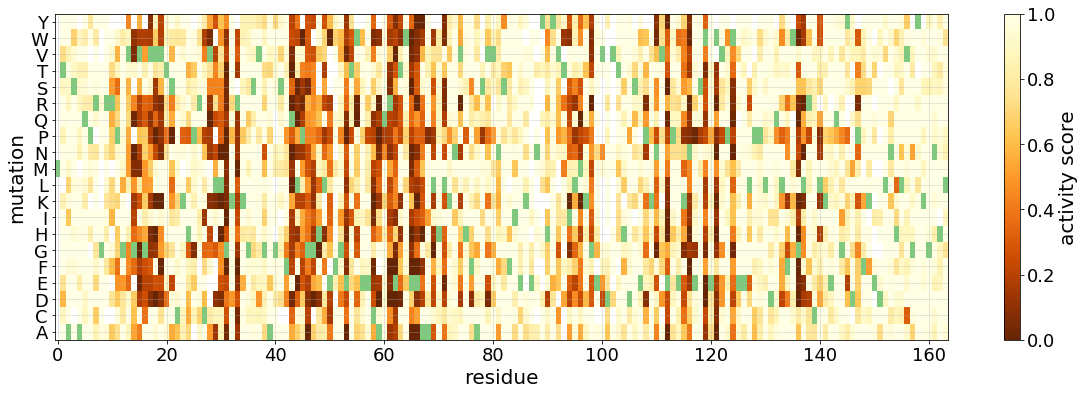

In [237]:
heatmap_scores(drug_sensitity_NUDT15_scores_norm,'activity score',NUDT15_WT_sequence,1.0,0,'YlOrBr_r')
plt.savefig('./Figures/NUDT15_heatmap_drug_MAVE.pdf')

- dataset coverage

In [238]:
count=0
count_gap_total=0
for i in range(drug_sensitity_NUDT15_scores_norm.shape[0]):
    count_gap=0
    for j in range(0,20):
        if np.isnan(drug_sensitity_NUDT15_scores_norm[i,j])==True:
            count_gap+=1
        count+=1
    count_gap_total+=count_gap
print("Variants coverage", 100-((count_gap_total-len(NUDT15_WT_sequence))/count*100))

Variants coverage 93.78048780487805


- VAMP-seq abundance scores

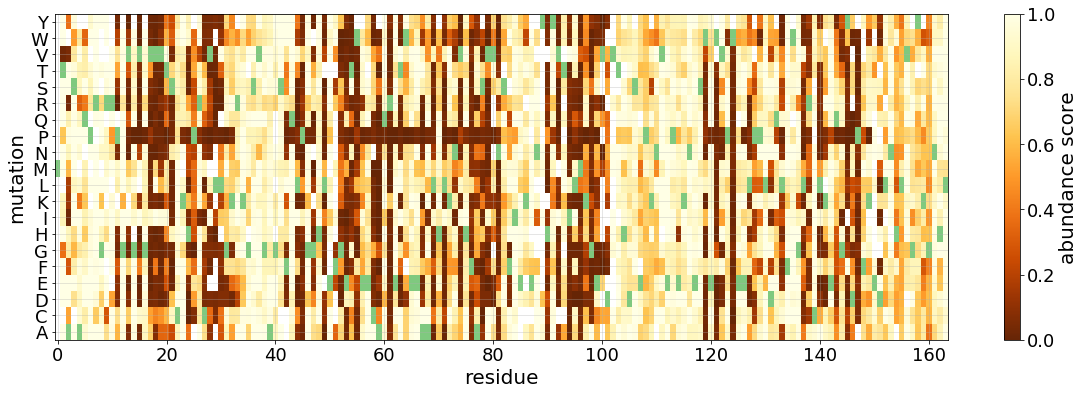

In [239]:
heatmap_scores(abundance_NUDT15_scores_norm,'abundance score',NUDT15_WT_sequence,0,1.0,'YlOrBr_r')
plt.savefig('./Figures/NUDT15_heatmap_abd_MAVE.pdf')

- dataset coverage

In [240]:
count=0
count_gap_total=0
for i in range(abundance_NUDT15_scores_norm.shape[0]):
    count_gap=0
    for j in range(0,20):
        if np.isnan(abundance_NUDT15_scores_norm[i,j])==True:
            count_gap+=1
        count+=1
    count_gap_total+=count_gap
print("Variants coverage", 100-((count_gap_total-len(NUDT15_WT_sequence))/count*100))

Variants coverage 93.4451219512195


### MAVE Score distribution Analysis
#### Drug sensitivity assay scores

over threshold variants: 1999  ( 68.64697802197803 %)


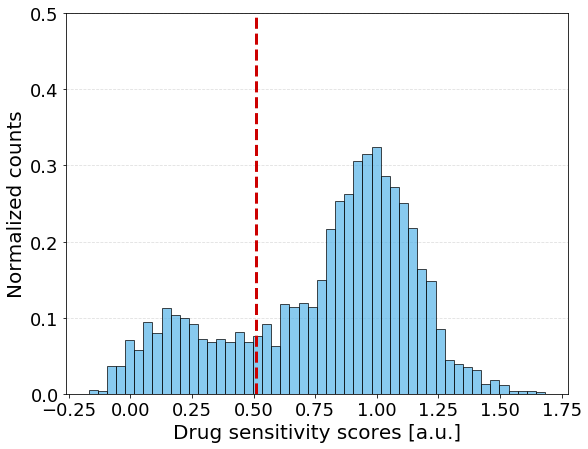

In [241]:
score_histogram(drug_sensitity_NUDT15_scores_norm,50,'#56b4e9','Drug sensitivity scores [a.u.]', 'True',0.7)

y_size=[0,0.5]
vert_line = np.array( [0.51 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.5)

plt.savefig('./Figures/NUDT15_histo_drug_MAVE.pdf')

##### Threshold definition: Tri-gaussian model fit

In [242]:
y,x,_=hist(drug_sensitity_NUDT15_scores_norm[~np.isnan(drug_sensitity_NUDT15_scores_norm)],100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(0.15,0.25,60,0.65,0.05,40,1,.25,105)
params,cov=curve_fit(bimodal,x,y,p0=expected)
sigma=sqrt(diag(cov))
plt.close()

In [243]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

           params     sigma
mu1      0.157477  0.030504
sigma1   0.145541  0.023546
A1      27.246162  2.216679
mu2      0.539757  0.037495
sigma2   0.142240  0.051359
A2      18.530772  2.347388
mu3      0.987141  0.008091
sigma3   0.173074  0.007030
A3      85.860769  1.604104


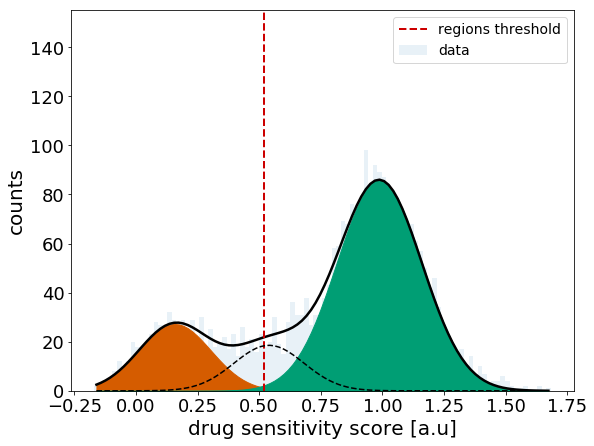

In [244]:
hist(drug_sensitity_NUDT15_scores_norm[~np.isnan(drug_sensitity_NUDT15_scores_norm)],100,alpha=.1,label='data')

plot(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='black',zorder=3,ls='--')
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#D55C00',zorder=2)
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='#009E74',zorder=2)
plot(x,bimodal(x,*params),color='black',lw=2.5)
y_size=[0,180]
vert_line = np.array( [0.52 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=2)
plt.xlabel("drug sensitivity score [a.u]")
plt.ylabel("counts")
plt.ylim(0,155)
legend()
plt.savefig("./Figures/NUDT15_experiment_activity_thresholds.pdf")

#### VAMP-seq abundance scores

over threshold variants: 1925  ( 66.35642881764909 %)


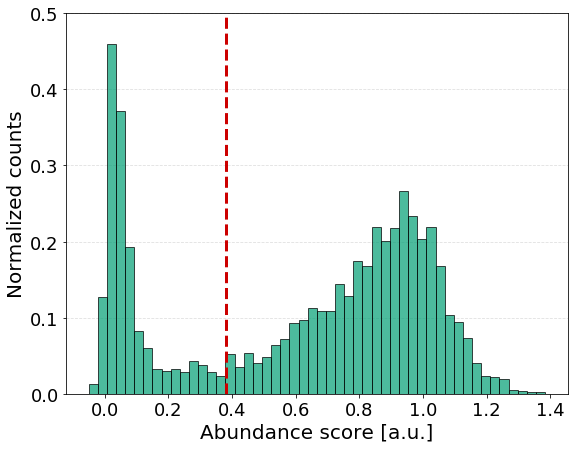

In [245]:
score_histogram(abundance_NUDT15_scores_norm,50,'#009e74','Abundance score [a.u.]', 'True',0.5)

y_size=[0,0.5]
vert_line = np.array( [0.38 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.5)


plt.savefig('./Figures/NUDT15_histo_abd_MAVE.pdf')

##### Threshold definition: Tri-gaussian model fit

In [246]:
y,x,_=hist(abundance_NUDT15_scores_norm[~np.isnan(abundance_NUDT15_scores_norm)],100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#expected=(0.15,0.25,60,0.65,0.05,40,1,.25,105)
params,cov=curve_fit(bimodal,x,y,p0=expected)
sigma=sqrt(diag(cov))
plt.close()

In [247]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

            params     sigma
mu1       0.035583  0.001275
sigma1    0.026707  0.001342
A1      136.464873  5.747832
mu2       0.624057  0.112960
sigma2    0.311622  0.065866
A2       19.498892  3.632086
mu3       0.938323  0.009001
sigma3    0.128321  0.015026
A3       54.911398  7.597700


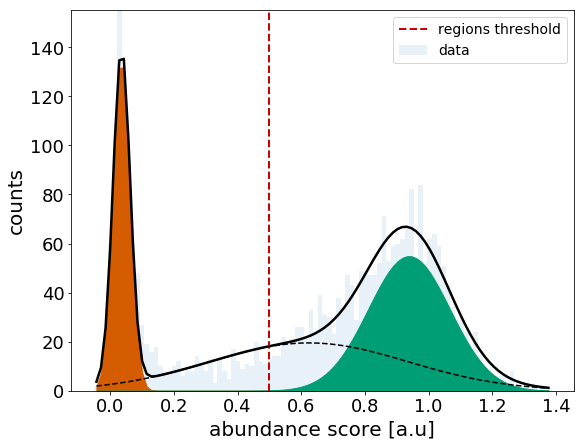

In [248]:
hist(abundance_NUDT15_scores_norm[~np.isnan(abundance_NUDT15_scores_norm)],100,alpha=.1,label='data')

plot(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='black',zorder=3,ls='--')
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#D55C00',zorder=2)
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='#009E74',zorder=2)
plot(x,bimodal(x,*params),color='black',lw=2.5)
y_size=[0,180]
vert_line = np.array( [0.50 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=2)
plt.xlabel("abundance score [a.u]")
plt.ylabel("counts")
plt.ylim(0,155)
legend()
plt.savefig("./Figures/NUDT15_experiment_abundance_thresholds.pdf")

### MAVE scores combined 2D histogram

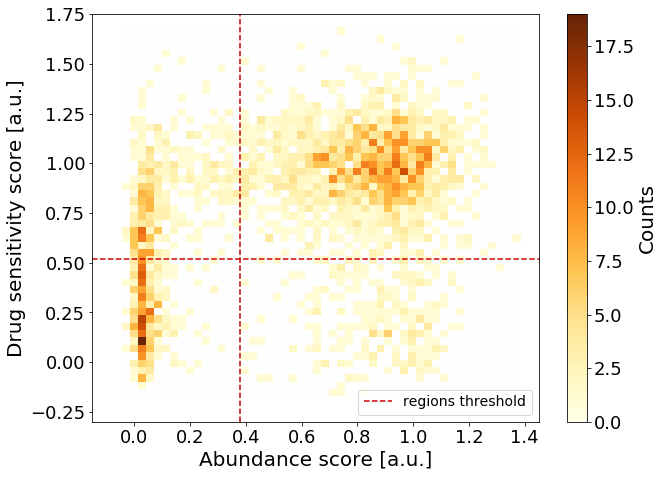

In [249]:
mpl.rcParams['figure.figsize']=(10,7.5)
y=[]; x=[]

# Custom threshold, already fixed on the single score distribution analysis
y_threshold=0.52       # drug sensitivity assay scores
x_threshold=0.38       # abundance scores

x_size=[-0.15,1.45]
y_size=[-0.30,1.75]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(drug_sensitity_NUDT15_scores_norm.shape[0]):
    for j in range(drug_sensitity_NUDT15_scores_norm.shape[1]):
        if np.isnan(drug_sensitity_NUDT15_scores_norm[i,j]) or np.isnan(abundance_NUDT15_scores_norm[i,j]):
            pass
        else:
            y.append(float(drug_sensitity_NUDT15_scores_norm[i,j]))
            x.append(float(abundance_NUDT15_scores_norm[i,j]))

# Common variants assays
x=np.array(x) 
y=np.array(y)

#Plot the 2D histogram
plt.xlabel("Abundance score [a.u.]")
plt.ylabel("Drug sensitivity score [a.u.]")

plt.hist2d(x,y,bins=50,cmap =newcmp)
cbar = plt.colorbar(label="Counts")

horiz_line = np.array( [y_threshold for i in range(len(x_size))])
plt.plot(x_size, horiz_line, 'r--',color='#cc0000') 

vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')

plt.legend(loc='lower right',fontsize=14)
plt.xlim(x_size[0],x_size[1])
plt.ylim(y_size[0],y_size[1])
plt.savefig('./Figures/NUDT15_2d_histo_MAVE.pdf')

### Color residues classification
Based on the location of the variants on the previous 2d histogram and using the designed thresholds
- (1) upper right: stable and functional - GREEN
- (2) upper left: unstable and fuctional - YELLOW
- (3) lower right: stable and unfunctional -BLUE
- (4) lower left: unstable and unfunctional -RED

In [250]:
class_labels_residues_exp=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
class_labels_residues_exp[:]=np.nan

In [251]:
# Assign the color to the variant based on its position in the 2d combined histogram
for i in range(class_labels_residues_exp.shape[0]):
    for j in range(class_labels_residues_exp.shape[1]):
        if np.isnan(drug_sensitity_NUDT15_scores_norm[i,j]) or np.isnan(abundance_NUDT15_scores_norm[i,j]):
            pass
        else:
            if drug_sensitity_NUDT15_scores_norm[i,j] <= y_threshold:
                if abundance_NUDT15_scores_norm[i,j] <= x_threshold:
                    class_labels_residues_exp[i,j]=1
                else:
                    class_labels_residues_exp[i,j]=3
            else:
                if abundance_NUDT15_scores_norm[i,j] <= x_threshold:
                    class_labels_residues_exp[i,j]=2
                else:
                    class_labels_residues_exp[i,j]=4

In [252]:
# Print information about the number of variants in each color region
counts = count_variants_regions(class_labels_residues_exp)
print('Variants per region:')
print(counts)
counts_perc = (counts/ np.sum(counts))*100
print('Variants per region percentage:')
print(counts_perc)

Variants per region:
[[ 410]
 [ 439]
 [ 270]
 [1703]]
Variants per region percentage:
[[14.52870305]
 [15.55634302]
 [ 9.56768249]
 [60.34727144]]


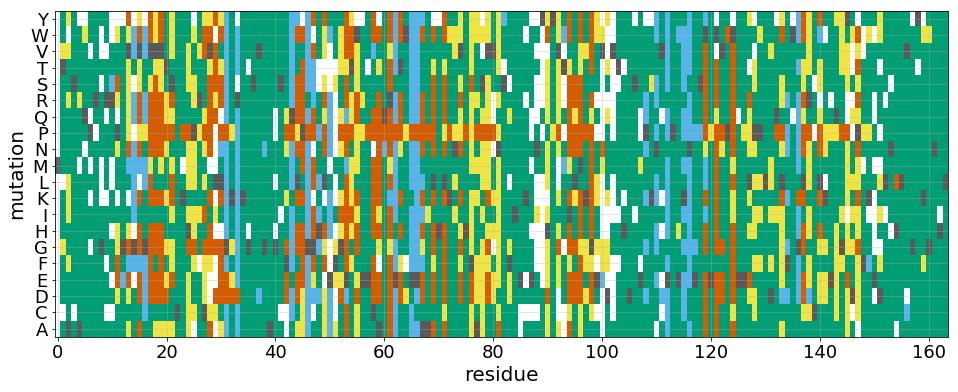

In [253]:
#Heatmap of the variant color classification
heatmap_classification_WT(class_labels_residues_exp,NUDT15_WT_sequence)
plt.savefig('./Figures/NUDT15_region_heatmap_MAVE.pdf')

- dataset coverage

In [254]:
count=0
count_gap_total=0
for i in range(class_labels_residues_exp.shape[0]):
    count_gap=0
    for j in range(0,20):
        if np.isnan(class_labels_residues_exp[i,j])==True:
            count_gap+=1
        count+=1
    count_gap_total+=count_gap
print("Variants coverage", 100-((count_gap_total-len(NUDT15_WT_sequence))/count*100))

Variants coverage 91.03658536585365


### Most common variant colour residue classification

In [255]:
# Use the most common value to define color for each residue
mode_value_class_NUDT15_exp=np.zeros(len(NUDT15_WT_sequence))

In [256]:
# Statistic on the number of residues per each region 

mode_value_class_NUDT15_exp, counts_mode=sp.stats.mode(class_labels_residues_exp,axis=1)
    
for i in range(1,5):
    count=0
    count_tot=0
    for j in range(len(mode_value_class_NUDT15_exp)):
        if np.isnan(mode_value_class_NUDT15_exp[j]) != True:
            count_tot+=1
        if mode_value_class_NUDT15_exp[j]==i:
            count+=1
    print( "There are ", count," out of ",count_tot,"(",(count/count_tot)*100, "%)" " residues in region",i)

There are  25  out of  163 ( 15.337423312883436 %) residues in region 1
There are  23  out of  163 ( 14.11042944785276 %) residues in region 2
There are  15  out of  163 ( 9.202453987730062 %) residues in region 3
There are  100  out of  163 ( 61.34969325153374 %) residues in region 4


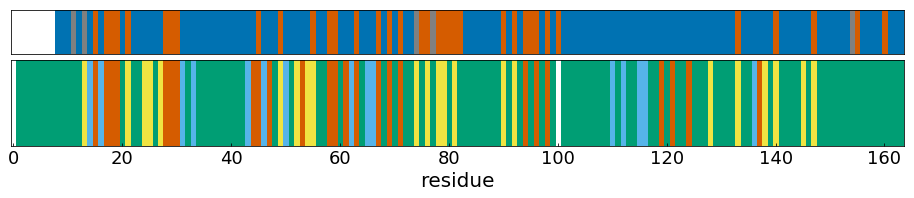

In [257]:
# Plot of the residue color classification and comparison with the solvent accessibility classification

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,2.5),gridspec_kw={"height_ratios" : [1.5,3], "hspace" : 0.1})

x=[ i for i in range(len(NUDT15_WT_sequence)) ]
x=np.array(x)

y=solvent_acc_NUDT15

y2_exp=np.copy(mode_value_class_NUDT15_exp)
# The results are show only for positions that have data for more than 5 mutations
for i in range(len(mode_value_class_NUDT15_exp)):
    if counts_mode[i] <5:
        y2_exp[i]=np.nan


ax2.set_yticks([],[])

#color code Solvent Accessibility analysis: green-exposed, gray-uncertain, red-buried
ax1.imshow(np.transpose(y),aspect='auto',cmap=mpl.colors.ListedColormap(["#d55c00",'gray',"#0072B2"]))

ax2.imshow(np.transpose(y2_exp), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442", "#56b4e9", "#009e74"]))

ax1.set_yticks([],[])
ax1.set_xticks([],[])

ax2.set_xlabel('residue',fontsize=20)

plt.tick_params(
    axis='y',         
    which='both',      
    left=False,
    labelleft=False) 

plt.tick_params(
    axis='x',         
    which='both',
    direction='in')

plt.savefig('./Figures/NUDT15_color_class_sa_MAVE.pdf', bbox_inches='tight')

- Statistic on solvent accessibility matched regions:

In [258]:
#print the location of the different buried residue in the different residue colour classes
print('red label - buried')
count=0
count_total=0
for i in range(len(NUDT15_WT_sequence)):
    if np.isnan(y[i])!=True and np.isnan(y2_exp[i])!= True:
        if y[i]==0:
            count_total+=1
            if y2_exp[i]==1:
                count+=1
print(count,' ', count_total, ', percentage:',count/count_total*100)

print('blue label - buried')
count=0
count_total=0
for i in range(len(NUDT15_WT_sequence)):
    if np.isnan(y[i])!=True and np.isnan(y2_exp[i])!= True:
        if y[i]==0:
            count_total+=1
            if y2_exp[i]==3:
                count+=1
print(count,' ', count_total, ', percentage:',count/count_total*100)

print('yellow label - buried')
count=0
count_total=0
for i in range(len(NUDT15_WT_sequence)):
    if np.isnan(y[i])!=True and np.isnan(y2_exp[i])!= True:
        if y[i]==0:
            count_total+=1
            if y2_exp[i]==2:
                count+=1
print(count,' ', count_total, ', percentage:',count/count_total*100)

print('green label - buried')
count=0
count_total=0
for i in range(len(NUDT15_WT_sequence)):
    if np.isnan(y[i])!=True and np.isnan(y2_exp[i])!= True:
        if y[i]==0:
            count_total+=1
            if y2_exp[i]==4:
                count+=1
print(count,' ', count_total, ', percentage:',count/count_total*100)

red label - buried
17   35 , percentage: 48.57142857142857
blue label - buried
0   35 , percentage: 0.0
yellow label - buried
12   35 , percentage: 34.285714285714285
green label - buried
6   35 , percentage: 17.142857142857142


### Error evaluation on experimental variants
Using a gaussian sampling of variant scores, we evaluate the robustness of our classification and how many variants and residues can change class.
The code is commented due to long execution time(~1/2h). You can run it to obtain the mean and percentage for each region.

In [259]:
#NUDT15_sampling_region_counts, NUDT15_sampling_region_percentages, NUDT15_sampling_residue_label_counts=gaussian_sampling_regions(drug_sensitity_NUDT15_scores_norm,abundance_NUDT15_scores_norm,drug_sensitity_NUDT15_errors,abundance_NUDT15_errors,x_threshold,y_threshold,10)

In [260]:
#print(NUDT15_sampling_region_counts)
#print(NUDT15_sampling_region_percentages)

In [261]:
#np.save("./Input_dataset/NUDT15_sampling_residue_label_counts.nparray",NUDT15_sampling_residue_label_counts, allow_pickle=False)

## Computational analysis

### Heatmaps computational scores
- Rosetta scores

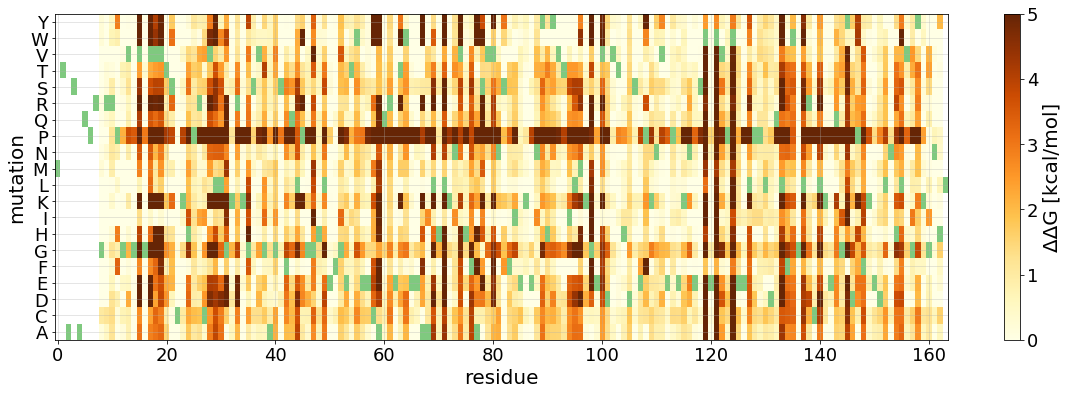

In [262]:
heatmap_scores(rosetta_NUDT15_ddg,'\u0394\u0394G [kcal/mol]',NUDT15_WT_sequence,0,5,'YlOrBr')
#plt.savefig('./Figures/NUDT15_heatmap_rosetta_COMP.pdf')

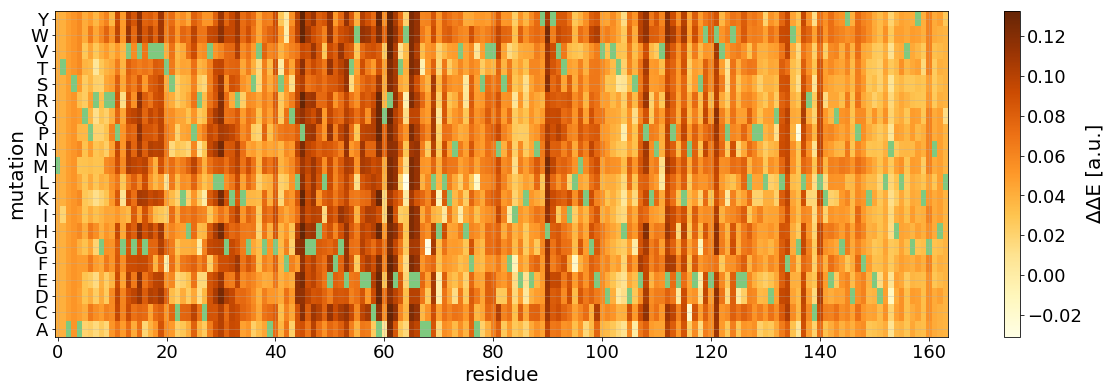

In [263]:
heatmap_scores(coevo_NUDT15_scores,'\u0394\u0394E [a.u.]',NUDT15_WT_sequence,np.amin(coevo_NUDT15_scores[~np.isnan(coevo_NUDT15_scores)]),np.amax(coevo_NUDT15_scores[~np.isnan(coevo_NUDT15_scores)]),'YlOrBr')
# plt.savefig('./Figures/NUDT15_heatmap_coevo_COMP.pdf')

In [264]:
#select the common data subset between the two algorithms
common_drug_sensitity_NUDT15_scores_norm=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
common_drug_sensitity_NUDT15_scores_norm[:]=np.nan

common_abundance_NUDT15_scores_norm=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
common_abundance_NUDT15_scores_norm[:]=np.nan

for i in range(len(NUDT15_WT_sequence)):
    for j in range(20):
        if np.isnan(drug_sensitity_NUDT15_scores_norm[i,j]) == False and np.isnan(drug_sensitity_NUDT15_scores_norm[i,j]) == False:
            common_drug_sensitity_NUDT15_scores_norm[i,j]=drug_sensitity_NUDT15_scores_norm[i,j]
            common_abundance_NUDT15_scores_norm[i,j]=abundance_NUDT15_scores_norm[i,j]


### Pearson's correlation coefficient with MAVE experiments
- Drug sensitivity MAVE vs Co-evolution scores

Pearson's correlation coefficient between data:  -0.5188051628490427
Pearson's correlation coefficient between data:  -0.47687836703593095


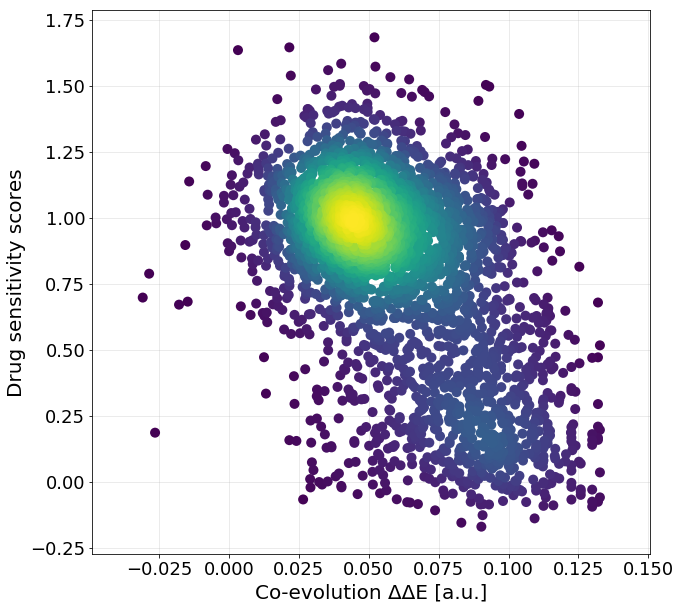

In [265]:
pearson_NUDT15_act_coevo=scores_density_plot(coevo_NUDT15_scores,common_drug_sensitity_NUDT15_scores_norm,"Co-evolution \u0394\u0394E [a.u.]", "Drug sensitivity scores")

- Drug sensitivity MAVE vs Rosetta scores

Pearson's correlation coefficient between data:  -0.35139579227803885
Pearson's correlation coefficient between data:  -0.29065777100515733


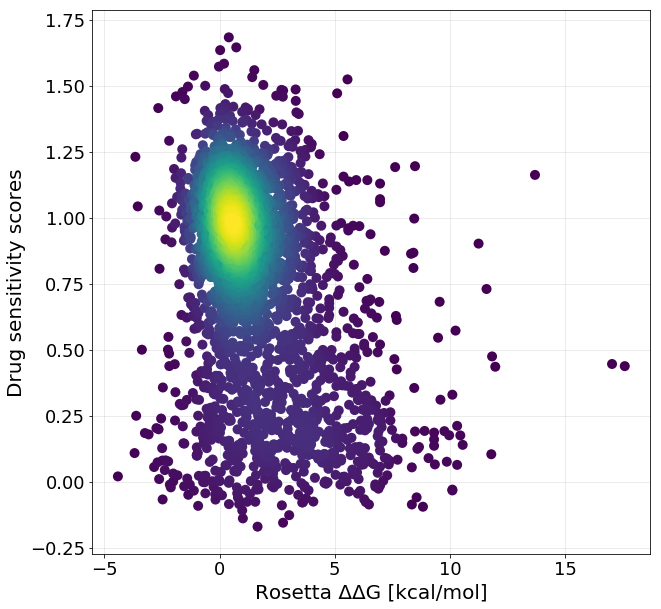

In [266]:
pearson_NUDT15_act_rosetta=scores_density_plot(rosetta_NUDT15_ddg,common_drug_sensitity_NUDT15_scores_norm,"Rosetta \u0394\u0394G [kcal/mol]", "Drug sensitivity scores")

- VAMP-seq MAVE vs Co-evolution scores

Pearson's correlation coefficient between data:  -0.4148708772934576
Pearson's correlation coefficient between data:  -0.3993108391745744


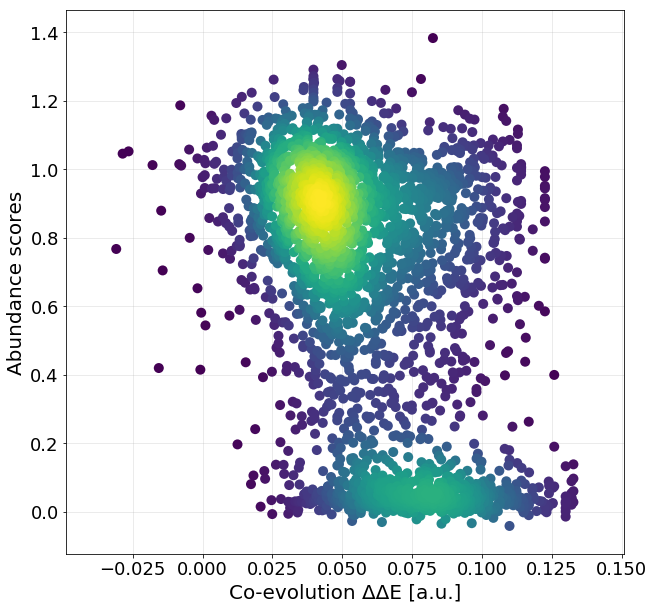

In [267]:
pearson_NUDT15_abd_coevo=scores_density_plot(coevo_NUDT15_scores,common_abundance_NUDT15_scores_norm,"Co-evolution \u0394\u0394E [a.u.]", "Abundance scores")

- VAMP-seq MAVE vs Rosetta scores

Pearson's correlation coefficient between data:  -0.5650084415137789
Pearson's correlation coefficient between data:  -0.5550979457226541


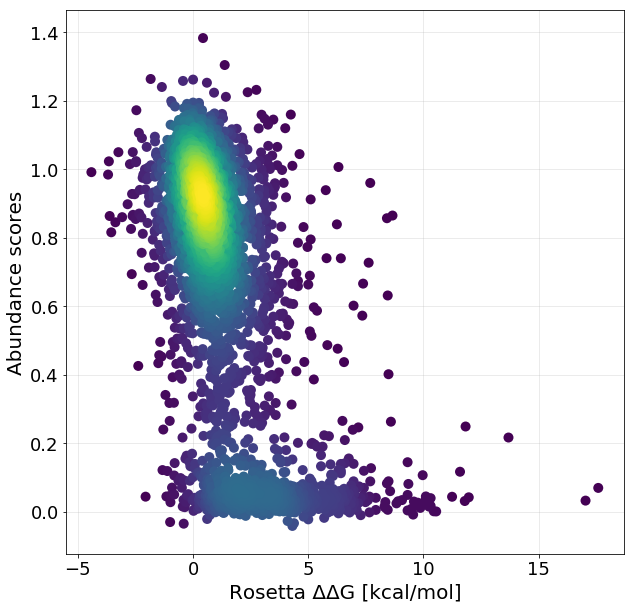

In [268]:
pearson_NUDT15_abd_rosetta=scores_density_plot(rosetta_NUDT15_ddg,common_abundance_NUDT15_scores_norm,"Rosetta \u0394\u0394G [kcal/mol]", "Abundance scores")

### Computational score distribution analysis
- Rosetta abundance scores

over threshold variants: 987  ( 33.51443123938879 %)


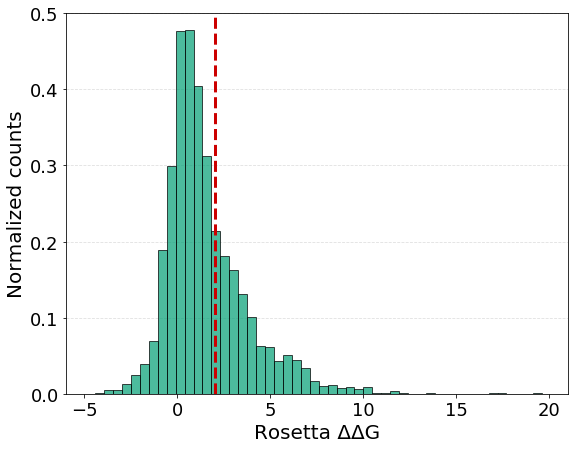

In [269]:
score_histogram(rosetta_NUDT15_ddg,50,'#009e74','Rosetta \u0394\u0394G', 'True',2.0)

y_size=[0,1]
vert_line = np.array( [2.0 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.5)
plt.xlim(-6,21)
plt.savefig('./Figures/NUDT15_rosetta_COMP.pdf')

- Co-evolution energies histogram

over threshold variants: 663  ( 21.27727856225931 %)


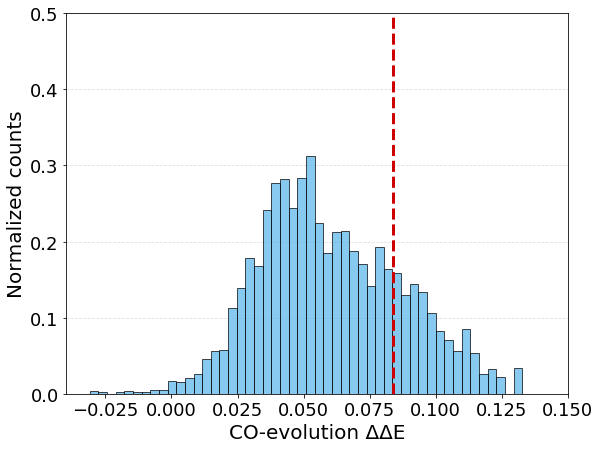

In [270]:
score_histogram(coevo_NUDT15_scores,50,'#56b4e9','CO-evolution \u0394\u0394E','True',0.084)

y_size=[0,1]
vert_line = np.array( [0.084 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.5)
plt.xlim(-0.04,0.15)
plt.savefig('./Figures/NUDT15_coevo_COMP.pdf')

### Computational scores combined 2D histogram

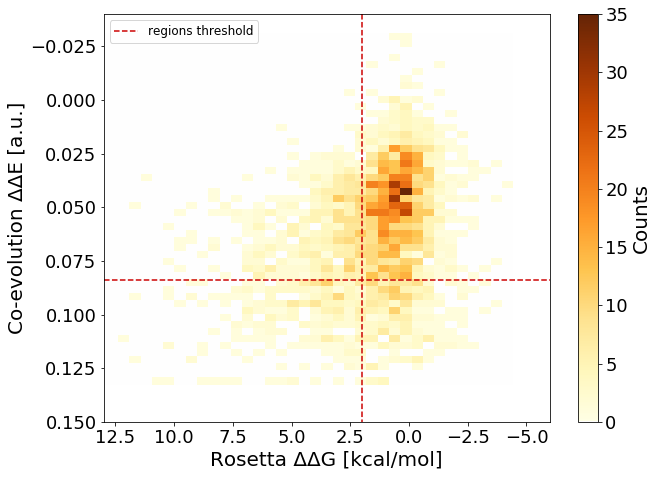

In [271]:
mpl.rcParams['figure.figsize']=(10,7.5)
y=[]; x=[]

# Custom threshold, already fixed on the single score distribution analysis
y_threshold=0.084 # Co-evolution score threshold
x_threshold=2.0 # Rosetta score threshold

x_size=[13,-6]
y_size=[-0.04,0.150]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(coevo_NUDT15_scores.shape[0]):
    for j in range(coevo_NUDT15_scores.shape[1]):
        if np.isnan(coevo_NUDT15_scores[i,j]) or np.isnan(rosetta_NUDT15_ddg[i,j]):
            pass
        else:
            y.append(float(coevo_NUDT15_scores[i,j]))
            x.append(float(rosetta_NUDT15_ddg[i,j]))

# Common variant assays
x=np.array(x)
y=np.array(y)

#Plot the 2d histogram
plt.xlabel("Rosetta \u0394\u0394G [kcal/mol]")
plt.ylabel("Co-evolution \u0394\u0394E [a.u.]")
plt.hist2d(x,y,bins=50,cmap =newcmp)# norm=mpl.colors.LogNorm()
cbar = plt.colorbar(label="Counts")

horiz_line = np.array( [y_threshold for i in range(len(x_size))])
plt.plot(x_size, horiz_line, 'r--',color='#cc0000') 

vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')

plt.legend(loc='upper left',fontsize=12)
plt.xlim(x_size[0],x_size[1])
plt.ylim(y_size[1],y_size[0])
plt.savefig('./Figures/NUDT15_2d_histo_COMP.pdf')

### Color residues classification
Based on the location of the variants ion the previous 2d histogram and using the designed thresholds
- (1) upper right: stable and functional - GREEN
- (2) upper left: unstable and fuctional - BLUE
- (3) lower right: stable and unfunctional - YELLOW
- (4) lower left: unstable and unfunctional -RED

In [272]:
class_labels_residues=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
class_labels_residues[:]=np.nan

In [273]:
# Assign the color to the variant based on its position in the 2d combined histogram

for i in range(class_labels_residues.shape[0]):
    for j in range(class_labels_residues.shape[1]):
        if np.isnan(coevo_NUDT15_scores[i,j]) or np.isnan(rosetta_NUDT15_ddg[i,j]):
            pass
        else:
            if coevo_NUDT15_scores[i,j] <= y_threshold:
                if rosetta_NUDT15_ddg[i,j] <= x_threshold:
                    class_labels_residues[i,j]=4
                else:
                    class_labels_residues[i,j]=2
            else:
                if rosetta_NUDT15_ddg[i,j] <= x_threshold:
                    class_labels_residues[i,j]=3
                else:
                    class_labels_residues[i,j]=1

In [274]:
# Print the information about variants in each colour region
counts = count_variants_regions(class_labels_residues)
print('Variants per region:')
print(counts)
counts_perc = (counts/ np.sum(counts))*100
print('Variants per region percentage:')
print(counts_perc)

Variants per region:
[[ 310]
 [ 605]
 [ 345]
 [1685]]
Variants per region percentage:
[[10.52631579]
 [20.54329372]
 [11.7147708 ]
 [57.21561969]]


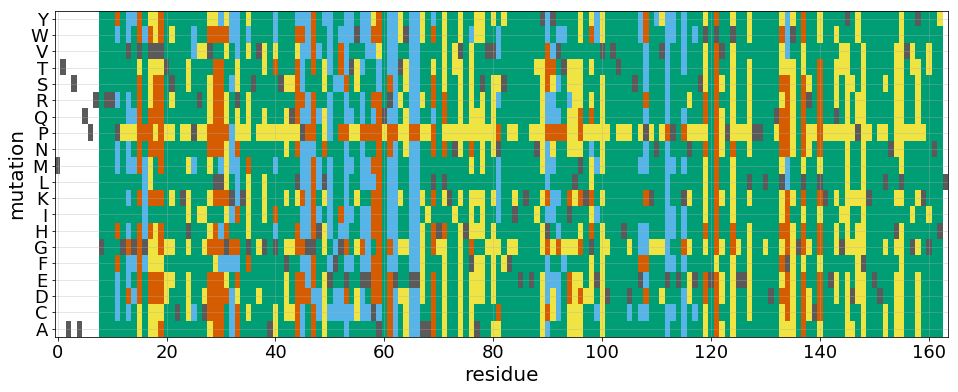

In [275]:
#Heatmap of the variant color classification
heatmap_classification_WT(class_labels_residues,NUDT15_WT_sequence)
#plt.savefig('./Figures/NUDT15_2d_heatmap_COMP.pdf')

### Residues most common variant colour classification

In [276]:
# Use the most common value to define acolor for each residue
mode_value_class=np.zeros(len(NUDT15_WT_sequence))

In [277]:
for i in range(len(NUDT15_WT_sequence)):
    mode_value_class, counts_mode=sp.stats.mode(class_labels_residues,axis=1)

Text(0.5, 0, 'residue')

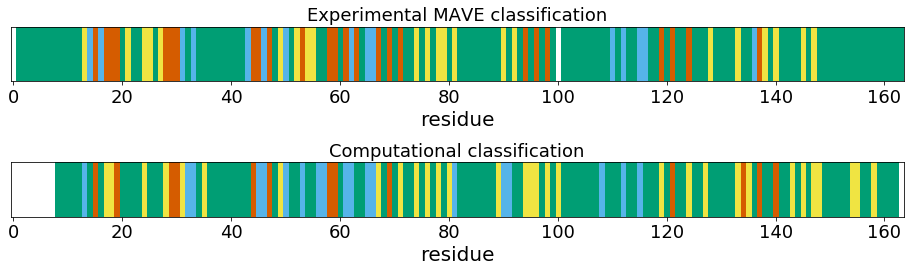

In [278]:
# Comparison with experimental MAVE residue colour classification
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3.5),gridspec_kw={"height_ratios" : [3,3], "hspace" : 1.5})
ax1.imshow(np.transpose(y2_exp), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))

ax2.imshow(np.transpose(mode_value_class),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442", "#56b4e9", "#009e74"]))
ax1.set_yticks([],[])
ax2.set_yticks([],[])
ax1.set_xlabel('residue')
ax2.set_xlabel('residue')

ax1.set_title('Experimental MAVE classification', fontsize='18')
ax2.set_title('Computational classification', fontsize='18')
#plt.grid(axis='x',which='both',color='gray', linestyle='-')

plt.xlabel("residue")
#plt.savefig('./Figures/NUDT15_comp_mode_comparison.pdf')

### MAVE coloured variants distribution in computational scores
- Red variants

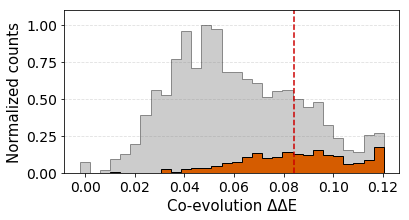

In [279]:
classification_histogram_shadowed(coevo_NUDT15_scores,class_labels_residues_exp,40,0.0,0.120,'#d55c00',"Co-evolution \u0394\u0394E",1)

y_size=[0,1.1]
vert_line = np.array( [y_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/NUDT15_comp_coevo_red_histo.pdf', bbox_inches='tight')

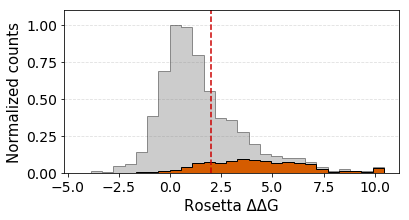

In [280]:
classification_histogram_shadowed(rosetta_NUDT15_ddg,class_labels_residues_exp,40,-4,10,'#d55c00',"Rosetta \u0394\u0394G",1)

y_size=[0,1.1]
vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/NUDT15_comp_rosetta_red_histo.pdf', bbox_inches='tight')

- Yellow variants

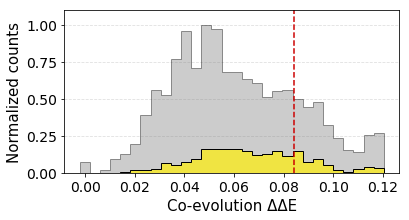

In [281]:
classification_histogram_shadowed(coevo_NUDT15_scores,class_labels_residues_exp,40,0.0,0.120,'#f0e442',"Co-evolution \u0394\u0394E",2)
y_size=[0,1.1]
vert_line = np.array( [y_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/NUDT15_comp_coevo_yellow_histo.pdf', bbox_inches='tight')

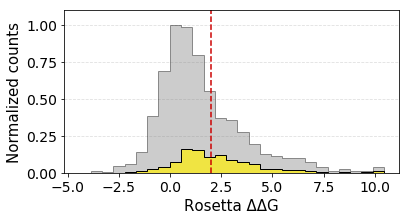

In [282]:
classification_histogram_shadowed(rosetta_NUDT15_ddg,class_labels_residues_exp,40,-4,10,'#f0e442',"Rosetta \u0394\u0394G",2)

y_size=[0,1.1]
vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/NUDT15_comp_rosetta_yellow_histo.pdf', bbox_inches='tight')

- Blue variants

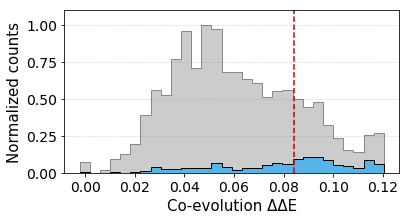

In [283]:
classification_histogram_shadowed(coevo_NUDT15_scores,class_labels_residues_exp,40,0.0,0.120,'#56b4e9',"Co-evolution \u0394\u0394E",3)
y_size=[0,1.2]
vert_line = np.array( [y_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/NUDT15_comp_coevo_blue_histo.pdf', bbox_inches='tight')

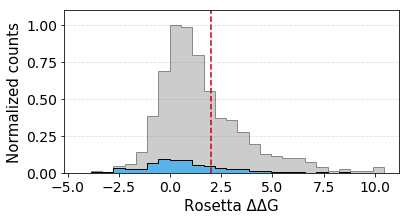

In [284]:
classification_histogram_shadowed(rosetta_NUDT15_ddg,class_labels_residues_exp,40,-4,10,'#56b4e9',"Rosetta \u0394\u0394G",3)

y_size=[0,1.1]
vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/NUDT15_comp_rosetta_blue_histo.pdf', bbox_inches='tight')

- Green variants

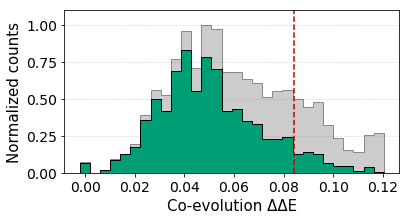

In [285]:
classification_histogram_shadowed(coevo_NUDT15_scores,class_labels_residues_exp,40,0.0,0.120,'#009e74',"Co-evolution \u0394\u0394E",4)
y_size=[0,1.1]
vert_line = np.array( [y_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/NUDT15_comp_coevo_green_histo.pdf', bbox_inches='tight')

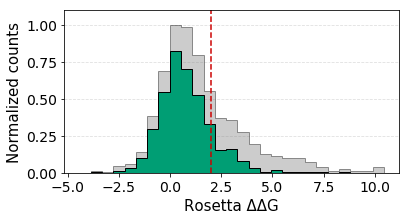

In [286]:
classification_histogram_shadowed(rosetta_NUDT15_ddg,class_labels_residues_exp,40,-4,10,'#009e74',"Rosetta \u0394\u0394G",4)

y_size=[0,1.1]
vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/NUDT15_comp_rosetta_green_histo.pdf', bbox_inches='tight')

### Comparison between the different computational methods and MAVE experiments

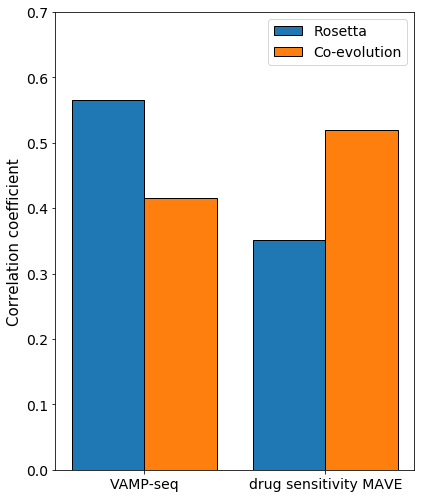

In [287]:
labels =['VAMP-seq', 'drug sensitivity MAVE']
rosetta_bar=[abs(pearson_NUDT15_abd_rosetta),abs(pearson_NUDT15_act_rosetta)]
coevo_bar=[abs(pearson_NUDT15_abd_coevo),abs(pearson_NUDT15_act_coevo)]

x=np.arange(len(labels))
width=0.40

fig, ax =plt.subplots(figsize=(6,7))
rects1=ax.bar(x-width/2,rosetta_bar,width,label='Rosetta',edgecolor='black')
rects2=ax.bar(x+width/2,coevo_bar,width,label='Co-evolution',edgecolor='black')

ax.set_ylabel('Correlation coefficient')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.ylim(0,0.7)
plt.savefig('./Figures/NUDT15_Pearson_comparison.pdf')

## Statistics on matched variants

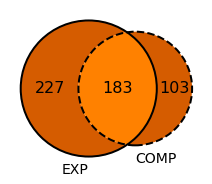

In [288]:
venn_data(class_labels_residues_exp,class_labels_residues,1,'#d55c00')
plt.savefig('./Figures/NUDT15_venn_red_variants.pdf', bbox_inches='tight')

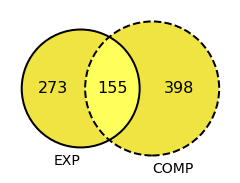

In [289]:
venn_data(class_labels_residues_exp,class_labels_residues,2,'#f0e442')
plt.savefig('./Figures/NUDT15_venn_yellow_variants.pdf', bbox_inches='tight')

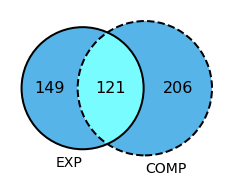

In [290]:
venn_data(class_labels_residues_exp,class_labels_residues,3,'#56b4e9')
plt.savefig('./Figures/NUDT15_venn_blue_variants.pdf', bbox_inches='tight')

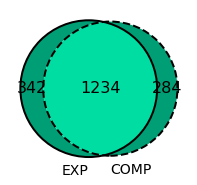

In [291]:
venn_data(class_labels_residues_exp,class_labels_residues,4,'#009e74')
plt.savefig('./Figures/NUDT15_venn_green_variants.pdf', bbox_inches='tight')

## Statistics on matched residues

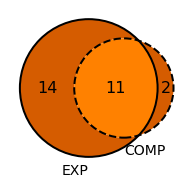

In [292]:
venn_data_mode(mode_value_class_NUDT15_exp,mode_value_class,1,'#d55c00')
plt.savefig('./Figures/NUDT15_venn_red.pdf', bbox_inches='tight')

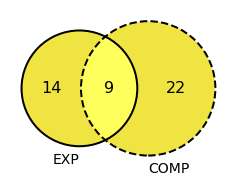

In [293]:
venn_data_mode(mode_value_class_NUDT15_exp,mode_value_class,2,'#f0e442')
plt.savefig('./Figures/NUDT15_venn_yellow.pdf', bbox_inches='tight')

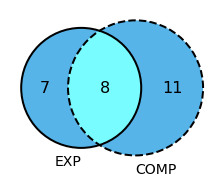

In [294]:
venn_data_mode(mode_value_class_NUDT15_exp,mode_value_class,3,'#56b4e9')
plt.savefig('./Figures/NUDT15_venn_blue.pdf', bbox_inches='tight')

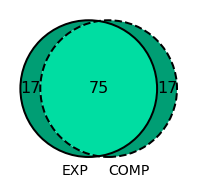

In [295]:
venn_data_mode(mode_value_class_NUDT15_exp,mode_value_class,4,'#009e74')
plt.savefig('./Figures/NUDT15_venn_green.pdf', bbox_inches='tight')

## MAVE position cluster analysis

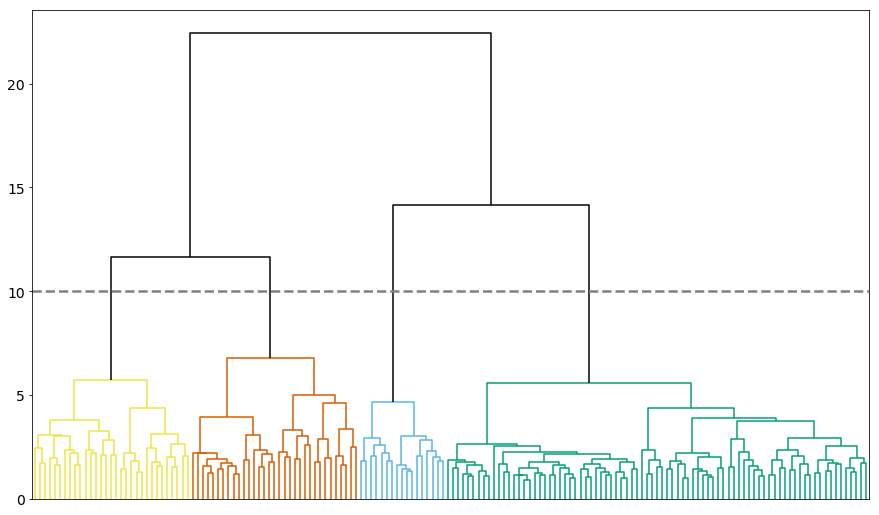

In [296]:
avg_act_score=np.mean(drug_sensitity_NUDT15_scores_norm[~np.isnan(drug_sensitity_NUDT15_scores_norm)])
avg_abd_score=np.mean(abundance_NUDT15_scores_norm[~np.isnan(abundance_NUDT15_scores_norm)])

residues_distances=[]
for r in range(0,len(NUDT15_WT_sequence)):
    temp=[]
    for j in range(20):
        if np.isnan(drug_sensitity_NUDT15_scores_norm[r,j])!=True  and alphabetAA_D_L[j+1] != NUDT15_WT_sequence[r]:
            temp.append(drug_sensitity_NUDT15_scores_norm[r,j])
        elif np.isnan(drug_sensitity_NUDT15_scores_norm[r,j])==True and alphabetAA_D_L[j+1] != NUDT15_WT_sequence[r]:
            temp.append(avg_act_score)
        elif alphabetAA_D_L[j+1] == NUDT15_WT_sequence[r]:
            temp.append(1.0)
    
    for j in range(20):
        if np.isnan(abundance_NUDT15_scores_norm[r,j])!=True  and alphabetAA_D_L[j+1] != NUDT15_WT_sequence[r]:
            temp.append(abundance_NUDT15_scores_norm[r,j])
        elif np.isnan(abundance_NUDT15_scores_norm[r,j])==True and alphabetAA_D_L[j+1] != NUDT15_WT_sequence[r]:
            temp.append(avg_abd_score)
        elif alphabetAA_D_L[j+1] == NUDT15_WT_sequence[r]:
            temp.append(1.0)

    residues_distances.append(temp)

Z = linkage(residues_distances, 'ward',metric='euclidean')

fig = plt.figure(figsize=(15,9))

sp.cluster.hierarchy.set_link_color_palette(["#f0e442","#d55c00", "#56b4e9", "#009e74"])
dn = dendrogram(Z,color_threshold=10,above_threshold_color='k',no_labels=True)
plt.axhline(y=10, c='grey', lw=2.5, linestyle='dashed')
plt.savefig('./Figures/NUDT15_cluster_tree.pdf')

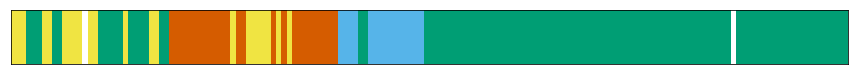

In [297]:
res_list=[]
for i in dn['ivl']:
    res_list.append(y2_exp[int(i)])
fig, ax = plt.subplots(figsize=(15,1))
ax.imshow(np.transpose(res_list), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))
ax.set_yticks([],[])
ax.set_xticks([],[])
plt.savefig('./Figures/NUDT15_cluster_color_comparison.pdf')

In [298]:
k=4
clusters_4=[fcluster(Z, k, criterion='maxclust')]
rearange_clusters_mode=np.empty(len(clusters_4[0]),dtype=float)
rearange_clusters_mode[:]=np.nan

dict_clusters={2:1,1:2,3:3,4:4}

for i in range(len(rearange_clusters_mode)):
    rearange_clusters_mode[i]=dict_clusters[clusters_4[0][i]]
    


In [299]:
labels=['COLOR','CLUSTER']

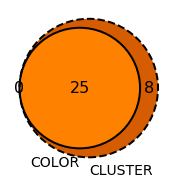

In [300]:
venn_data_mode(y2_exp,rearange_clusters_mode,1,'#d55c00',labels=labels)
plt.savefig('./Figures/NUDT15_clusters_venn_red.pdf', bbox_inches='tight')

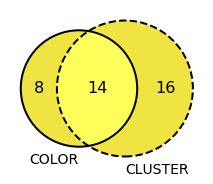

In [301]:
venn_data_mode(y2_exp,rearange_clusters_mode,2,'#f0e442',labels=labels)
plt.savefig('./Figures/NUDT15_clusters_yellow.pdf', bbox_inches='tight')

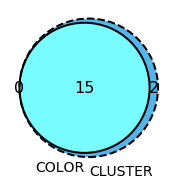

In [302]:
venn_data_mode(y2_exp,rearange_clusters_mode,3,'#56b4e9',labels=labels)
plt.savefig('./Figures/NUDT15_clusters_blue.pdf', bbox_inches='tight')

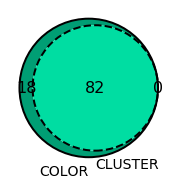

In [303]:
venn_data_mode(y2_exp,rearange_clusters_mode,4,'#009e74',labels=labels)
plt.savefig('./Figures/NUDT15_clusters_green.pdf', bbox_inches='tight')

## Computational position cluster analysis

In [304]:
normalized_coevo_scores=np.copy(coevo_NUDT15_scores)
c_min_act=np.percentile(coevo_NUDT15_scores[~np.isnan(coevo_NUDT15_scores)],5)
c_max_act=np.percentile(coevo_NUDT15_scores[~np.isnan(coevo_NUDT15_scores)],95)
print(c_max_act,c_min_act)
for i in range(coevo_NUDT15_scores.shape[0]):
    for j in range(coevo_NUDT15_scores.shape[1]):
        normalized_coevo_scores[i,j]=(coevo_NUDT15_scores[i,j]-c_min_act)/(c_max_act-c_min_act)

0.109131 0.021515424999999998


In [305]:
normalized_rosetta_scores=np.copy(rosetta_NUDT15_ddg)
r_min_act=np.percentile(rosetta_NUDT15_ddg[~np.isnan(rosetta_NUDT15_ddg)],5)
r_max_act=np.percentile(rosetta_NUDT15_ddg[~np.isnan(rosetta_NUDT15_ddg)],95)
print(r_max_act,r_min_act,)
for i in range(rosetta_NUDT15_ddg.shape[0]):
    for j in range(rosetta_NUDT15_ddg.shape[1]):
        normalized_rosetta_scores[i,j]=(rosetta_NUDT15_ddg[i,j]-r_min_act)/(r_max_act-r_min_act)

6.0344827586206895 -0.9896551724137932


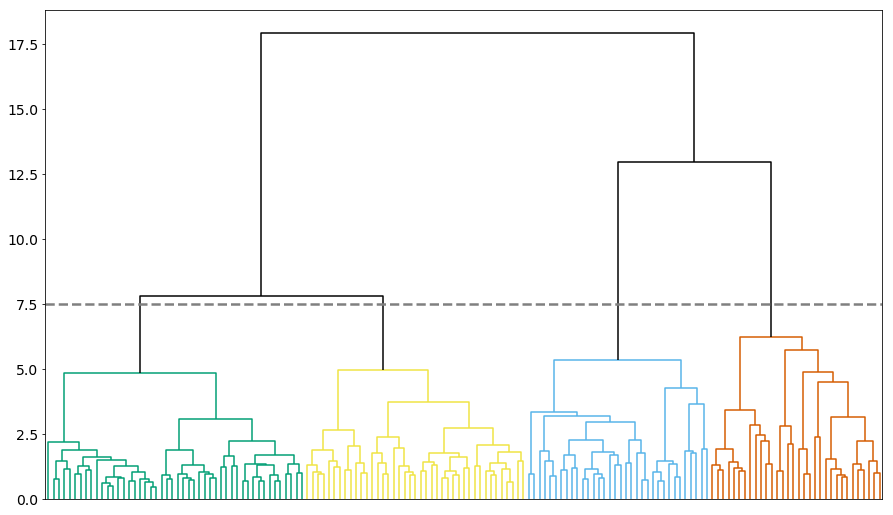

In [306]:
residues_distances=[]
mapping_pos=[]
for r in range(0,len(NUDT15_WT_sequence)):
    temp=[]
    if np.isnan(mode_value_class[r]) != True:
        for j in range(20):
                if np.isnan(normalized_coevo_scores[r,j])!=True  and alphabetAA_D_L[j+1] != NUDT15_WT_sequence[r]:
                    temp.append(normalized_coevo_scores[r,j])
                elif np.isnan(normalized_coevo_scores[r,j])==True and alphabetAA_D_L[j+1] != NUDT15_WT_sequence[r]:
                    temp.append(np.mean(normalized_coevo_scores[r,:][~np.isnan(normalized_coevo_scores[r,:])]))
                elif alphabetAA_D_L[j+1] == NUDT15_WT_sequence[r]:
                    temp.append(0)
    
        for j in range(20):
                if np.isnan(normalized_rosetta_scores[r,j])!=True  and alphabetAA_D_L[j+1] != NUDT15_WT_sequence[r]:
                    temp.append(normalized_rosetta_scores[r,j])
                elif np.isnan(normalized_rosetta_scores[r,j])==True and alphabetAA_D_L[j+1] != NUDT15_WT_sequence[r]:
                    temp.append(np.mean(normalized_rosetta_scores[r,:][~np.isnan(abundance_NUDT15_scores[r,:])]))
                elif alphabetAA_D_L[j+1] == NUDT15_WT_sequence[r]:
                    temp.append(0)

        residues_distances.append(temp)
        mapping_pos.append(r)
    
Z = linkage(residues_distances, 'ward',metric='euclidean')

fig = plt.figure(figsize=(15,9))

sp.cluster.hierarchy.set_link_color_palette(["#009e74","#f0E442","#56b4e9","#d55c00"])
dn = dendrogram(Z,color_threshold=7.5,above_threshold_color='k',no_labels=True)
plt.axhline(y=7.5, c='grey', lw=2.5, linestyle='dashed')
plt.savefig('./Figures/NUDT15_comp_cluster_tree.pdf')

- agreement with computational threshold classification

155


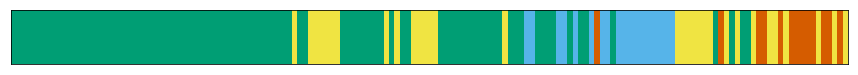

In [307]:
res_list=[]
print(len(mapping_pos))
for i in dn['ivl']:
    res_list.append(mode_value_class[mapping_pos[int(i)]])
fig, ax = plt.subplots(figsize=(15,1))
ax.imshow(np.transpose(res_list), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))
ax.set_yticks([],[])
ax.set_xticks([],[])
plt.savefig('./Figures/NUDT15_comp_comp_cluster_color_comparison.pdf')

- agreement with MAVE threshold classification

155


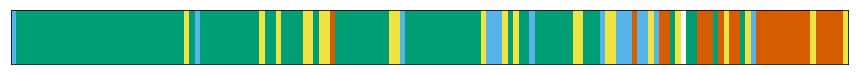

In [308]:
res_list=[]
print(len(mapping_pos))
for i in dn['ivl']:
    res_list.append(y2_exp[mapping_pos[int(i)]])
fig, ax = plt.subplots(figsize=(15,1))
ax.imshow(np.transpose(res_list), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))
ax.set_yticks([],[])
ax.set_xticks([],[])
plt.savefig('./Figures/NUDT15_comp_exp_cluster_color_comparison.pdf')